# West Nile Analysis

In [107]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,  AdaBoostClassifier
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



In [108]:
train = pd.read_csv('../data/trainw.csv')
test  = pd.read_csv('../data/testw.csv')
train.columns = [col.lower().replace(' ', '_') for col in train.columns]
test.columns = [col.lower().replace(' ', '_') for col in test.columns]


#read cleaned data and bring and trainform all variables to lower_camel_case
                    

In [109]:
train.isnull().sum() 


unnamed:_0                             0
index                                  0
date                                   0
address                                0
block                                  0
street                                 0
trap                                   0
addressnumberandstreet                 0
latitude                               0
longitude                              0
addressaccuracy                        0
nummosquitos                           0
wnvpresent                             0
year                                   0
month                                  0
day                                    0
tmax_x                                 0
tmin_x                                 0
tavg_x                                 0
depart_x                               0
dewpoint_x                             0
wetbulb_x                              0
heat_x                                 0
cool_x                                 0
sunrise_x       

In [110]:
train.columns

Index(['unnamed:_0', 'index', 'date', 'address', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'year', 'month', 'day', 'tmax_x',
       'tmin_x', 'tavg_x', 'depart_x', 'dewpoint_x', 'wetbulb_x', 'heat_x',
       'cool_x', 'sunrise_x', 'sunset_x', 'codesum_x', 'depth_x', 'water1_x',
       'snowfall_x', 'preciptotal_x', 'stnpressure_x', 'sealevel_x',
       'resultspeed_x', 'resultdir_x', 'avgspeed_x', 'tmax_y', 'tmin_y',
       'tavg_y', 'depart_y', 'dewpoint_y', 'wetbulb_y', 'heat_y', 'cool_y',
       'sunrise_y', 'sunset_y', 'codesum_y', 'depth_y', 'water1_y',
       'snowfall_y', 'preciptotal_y', 'stnpressure_y', 'sealevel_y',
       'resultspeed_y', 'resultdir_y', 'avgspeed_y', 'species_culex_pipiens',
       'species_culex_pipiens/restuans', 'species_culex_restuans',
       'species_culex_salinarius', 'species_culex_tarsalis',
       'species_culex_territans', 'distance', 'distance_3', '

In [111]:
#included features to set up X and Y from training set
# features = [ 'trap', 'block', 'month', 'street', 'tmax_y', 
#             'tavg_y', 'dewpoint_y',
#             'preciptotal_y', 'stnpressure_y',
#             'sealevel_y', 'resultspeed_y', 'resultdir_y', 'avgspeed_y', 'distance',
#             'dist_species_culex_pipiens',
#             'dist_species_culex_pipiens/restuans', 'dist_species_culex_restuans',
#             'dist_species_culex_salinarius', 
#             'dist_species_culex_territans',
#             'month_dist_temp_y',
#             'month_and_dist', 'distance_3','distance_5'
            
#            ]

#Found by running ada boost feature importance-these had a score above 0
features=[ 'month_dist_temp_x', 'distance',
       'latitude', 'sunrise_x', 'distance_5', 
       'resultspeed_y', 'trap', 'street', 'trap_and_temp_x',
       'dist_species_culex_pipiens/restuans', 'distance_3', 
       'sealevel_x', 'longitude', 'block_and_precip_x',
       'species_culex_territans', 
       'depart_x',  'tmin_x', 'dist_species_culex_pipiens']




X = train[features]
y = train['wnvpresent']

In [112]:
#do a train test split with stratified data due to unbalanced classes

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

#### Dealing with unbalanced classes

We have unbalanced classes in our data set with only about 5.24% of our observations containing the West Nile Virus.  In order to better predict the minority class which is the class of interest we are oversampling the data where West Nile is present in our training data.  We leave the testing data untouched.

In [113]:
#merging the target variable back onto the training data in order to sample off its value

datasets = (X_train, y_train)
traincombined = pd.concat(datasets, axis = 1)
traincombined.head()

,month_dist_temp_x,distance,latitude,sunrise_x,distance_5,resultspeed_y,trap,street,trap_and_temp_x,dist_species_culex_pipiens/restuans,distance_3,sealevel_x,longitude,block_and_precip_x,species_culex_territans,depart_x,tmin_x,dist_species_culex_pipiens,wnvpresent
447,465.589659,0.863803,41.979243,432,1.000325,10.3,18,115,1530,0.863803,0.939648,29.84,-87.750938,2343,0,3,69,0.000000,0.0
8076,1220.375902,1.883296,41.964242,522,12.079074,4.3,2,33,172,1.883296,17.987766,30.11,-87.757639,1920,0,5,57,0.000000,1.0
1219,638.910277,1.050839,41.954690,459,1.176855,4.9,1,36,80,0.000000,1.117797,29.89,-87.800991,1820,0,4,71,1.050839,0.0
5333,910.300844,1.605469,41.911824,438,9.018770,2.1,28,40,2464,1.605469,8.979138,29.91,-87.726737,426,0,7,73,0.000000,0.0
3551,152.729680,0.340914,41.907645,431,10.600795,10.1,97,29,6790,0.000000,12.001283,29.87,-87.760886,280,0,-10,57,0.000000,0.0


In [114]:
#Select West nile cases and generate 5000 samples
west_nile = traincombined[traincombined.wnvpresent == 1]
extra_west_nile = west_nile.sample(n = 4000, replace = True,  axis = 0)

In [115]:
#merge samples onto original data
merge = [traincombined, extra_west_nile]
traincombined = pd.concat(merge, axis = 0)

In [116]:
#Break our training data back into a X and a y
X_train = traincombined[features]
y_train = traincombined['wnvpresent']

### Set up our model for grid search evaluation

In [117]:
ad = AdaBoostClassifier()
rf_params = {
    'n_estimators'       : [ 600],
    'learning_rate'          : [    .9]
   }



In [118]:
gs = GridSearchCV(ad, 
                  param_grid=rf_params,
                 scoring = 'recall', 
                  cv = 4)


In [119]:
gs.fit(X_train, y_train)
print("Print Train Score : " , gs.best_score_)
print("Print Test Score  : " , gs.score(X_test, y_test))
print("Print Best Params : " , gs.best_params_)

Print Train Score :  0.9099828975779424
Print Test Score  :  0.5591397849462365
Print Best Params :  {'learning_rate': 0.9, 'n_estimators': 600}


In [120]:
y_hat = gs.predict(X_test)
y_hat_train = gs.predict(X_train)
y_hat_prob = gs.predict_proba(X_test)


In [121]:
ad.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [122]:
ad.feature_importances_

array([0.14, 0.02, 0.06, 0.14, 0.06, 0.06, 0.02, 0.02, 0.04, 0.06, 0.04,
       0.02, 0.02, 0.1 , 0.02, 0.04, 0.1 , 0.04])

In [123]:
# View Feature Importance from ADA Boost model
raw_data={'ADA Imp':ad.feature_importances_}
ada2_df=pd.DataFrame(raw_data,train[features].columns)
ada2_df=ada2_df.sort_values('ADA Imp', ascending=False) 
ada2_df

,ADA Imp
month_dist_temp_x,0.14
sunrise_x,0.14
tmin_x,0.10
block_and_precip_x,0.10
resultspeed_y,0.06
dist_species_culex_pipiens/restuans,0.06
distance_5,0.06
latitude,0.06
trap_and_temp_x,0.04
distance_3,0.04


In [124]:
ada2_df=ada2_df.loc[ada2_df['ADA Imp'] != 0]
ada2_df.loc[ada2_df['ADA Imp'] != 0]

,ADA Imp
month_dist_temp_x,0.14
sunrise_x,0.14
tmin_x,0.10
block_and_precip_x,0.10
resultspeed_y,0.06
dist_species_culex_pipiens/restuans,0.06
distance_5,0.06
latitude,0.06
trap_and_temp_x,0.04
distance_3,0.04


In [125]:
print(classification_report( y_train, y_hat_train))

             precision    recall  f1-score   support

        0.0       0.94      0.88      0.91      6079
        1.0       0.84      0.92      0.88      4277

avg / total       0.90      0.89      0.89     10356



In [126]:
print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

        0.0       0.98      0.88      0.93      2026
        1.0       0.18      0.56      0.27        93

avg / total       0.94      0.87      0.90      2119



In [127]:
confusion_matrix(y_train, y_hat_train)

array([[5322,  757],
       [ 354, 3923]])

In [128]:
confusion_matrix(y_test, y_hat)

array([[1783,  243],
       [  41,   52]])

In [129]:
y_test.value_counts()

0.0    2026
1.0      93
Name: wnvpresent, dtype: int64

In [130]:
X = test[features]
predict = (gs.predict(X))
predprob = gs.predict_proba(X)

In [131]:
predprob

array([[0.51586595, 0.48413405],
       [0.51633738, 0.48366262],
       [0.51564548, 0.48435452],
       ...,
       [0.50117789, 0.49882211],
       [0.50117789, 0.49882211],
       [0.50117789, 0.49882211]])

In [132]:
y_train_pred_proba = gs.predict_proba(X_train)
y_train_pred = gs.predict(X_train)
y_test_pred_proba = gs.predict_proba(X_test)
y_test_pred = gs.predict(X_test)

In [133]:
#modifying train and testing data to allow for changing prob thresholds and printing the 
#roc curves
X_train.loc[:, 'actual_y'] = y_train
X_train.loc[:, 'predicted_label'] = y_train_pred
X_train.loc[:, 'predicted_proba'] = y_train_pred_proba[:, 1]


In [134]:
X_test.loc[:, 'actual_y'] = y_test
X_test.loc[:, 'predicted_label'] = y_test_pred
X_test.loc[:, 'predicted_proba'] = y_test_pred_proba[:, 1]


In [135]:
mask_misclassification = (X_test[X_test['predicted_label'] == 0])
misclassifications = (mask_misclassification[mask_misclassification['actual_y'] == 1])
misclassifications

,month_dist_temp_x,distance,latitude,sunrise_x,distance_5,resultspeed_y,trap,street,trap_and_temp_x,dist_species_culex_pipiens/restuans,...,sealevel_x,longitude,block_and_precip_x,species_culex_territans,depart_x,tmin_x,dist_species_culex_pipiens,actual_y,predicted_label,predicted_proba
1372,691.610537,1.137517,41.836644,459,1.784385,4.9,25,68,2000,0.000000,...,29.89,-87.677737,1190,0,4,71,0.000000,1.0,0.0,0.499447
1132,474.689640,0.723612,41.903002,451,1.325093,6.3,104,49,9464,0.000000,...,29.76,-87.688267,76,0,9,72,0.000000,1.0,0.0,0.498841
4395,1289.907125,2.018634,41.904194,530,10.323048,1.1,124,26,10416,2.018634,...,30.07,-87.756155,183,0,7,58,0.000000,1.0,0.0,0.498931
1166,969.812949,1.478373,41.803423,451,1.766336,6.3,60,89,5460,0.000000,...,29.76,-87.642984,2584,0,9,72,1.478373,1.0,0.0,0.499576
1055,779.685825,1.188545,42.011601,451,1.188545,6.3,14,38,1274,0.000000,...,29.76,-87.811506,3876,0,9,72,1.188545,1.0,0.0,0.499614
1667,1966.310160,3.072360,41.662014,506,3.479604,5.1,83,98,7470,3.072360,...,29.94,-87.724608,1971,0,9,69,0.000000,1.0,0.0,0.499286
3773,785.755848,1.516903,41.704336,440,8.326411,9.2,71,93,5964,0.000000,...,29.86,-87.703736,1188,0,0,64,0.000000,1.0,0.0,0.498576
2009,550.867023,0.805361,41.825610,520,1.610664,2.2,43,82,3827,0.805361,...,30.00,-87.726549,1452,0,8,63,0.000000,1.0,0.0,0.498146
8236,1804.545647,2.784793,41.673408,528,12.992680,6.8,80,64,6560,2.784793,...,29.98,-87.599862,128,0,7,62,0.000000,1.0,0.0,0.497906
4397,2338.606997,3.659792,41.951866,530,13.141484,1.1,122,44,10248,0.000000,...,30.07,-87.725057,1464,0,7,58,0.000000,1.0,0.0,0.495017


In [136]:
#print out confusion matrices from .1 .5 by .02 for Xtest and Xtrain
for prob in range(10, 50, 2):
    proba = prob/100
    
    X_test.loc[:, 'predicted_label']= X_test['predicted_proba'].map(
    lambda p: 1 if p > proba else 0)
    
    X_train.loc[:, 'predicted_label']= X_train['predicted_proba'].map(
    lambda p: 1 if p > proba else 0)
    
    X_test['predicted_label']
    print('Test  ' + str(proba))
    print(confusion_matrix(y_test, X_test['predicted_label']))
    print(' Train  ' + str(proba))
    print(confusion_matrix(y_train, X_train['predicted_label']))


Test  0.1
[[   0 2026]
 [   0   93]]
 Train  0.1
[[   0 6079]
 [   0 4277]]
Test  0.12
[[   0 2026]
 [   0   93]]
 Train  0.12
[[   0 6079]
 [   0 4277]]
Test  0.14
[[   0 2026]
 [   0   93]]
 Train  0.14
[[   0 6079]
 [   0 4277]]
Test  0.16
[[   0 2026]
 [   0   93]]
 Train  0.16
[[   0 6079]
 [   0 4277]]
Test  0.18
[[   0 2026]
 [   0   93]]
 Train  0.18
[[   0 6079]
 [   0 4277]]
Test  0.2
[[   0 2026]
 [   0   93]]
 Train  0.2
[[   0 6079]
 [   0 4277]]
Test  0.22
[[   0 2026]
 [   0   93]]
 Train  0.22
[[   0 6079]
 [   0 4277]]
Test  0.24
[[   0 2026]
 [   0   93]]
 Train  0.24
[[   0 6079]
 [   0 4277]]
Test  0.26
[[   0 2026]
 [   0   93]]
 Train  0.26
[[   0 6079]
 [   0 4277]]
Test  0.28
[[   0 2026]
 [   0   93]]
 Train  0.28
[[   0 6079]
 [   0 4277]]
Test  0.3
[[   0 2026]
 [   0   93]]
 Train  0.3
[[   0 6079]
 [   0 4277]]
Test  0.32
[[   0 2026]
 [   0   93]]
 Train  0.32
[[   0 6079]
 [   0 4277]]
Test  0.34
[[   0 2026]
 [   0   93]]
 Train  0.34
[[   0 6079]
 [   0

In [137]:
fpr, tpr, _ = roc_curve(y_train, X_train['predicted_proba'])
roc_auc = auc(fpr, tpr)


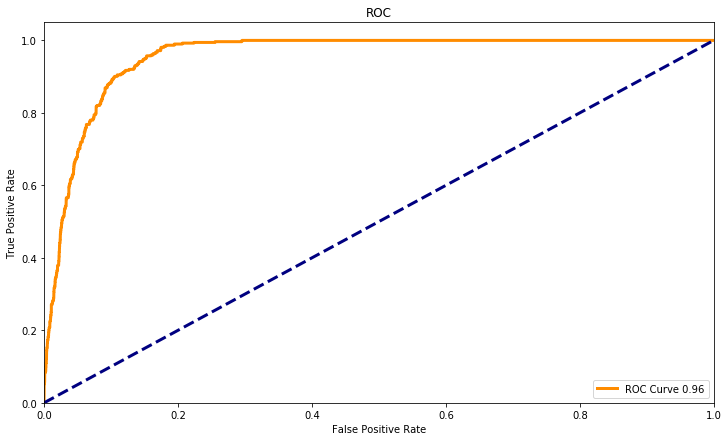

In [138]:
# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [139]:
fpr, tpr, _ = roc_curve(y_test, X_test['predicted_proba'])
roc_auc = auc(fpr, tpr)

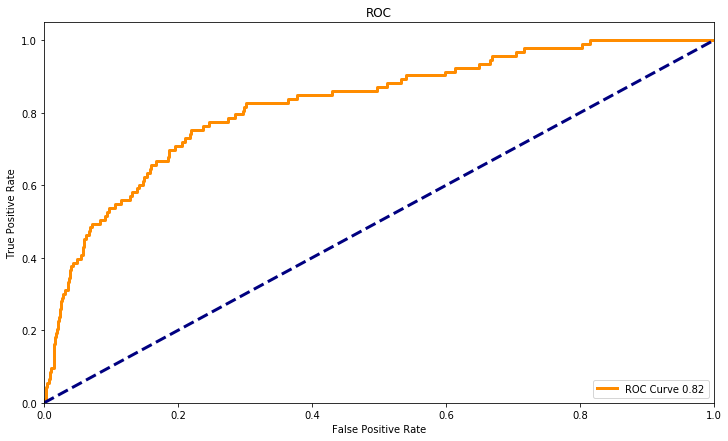

In [140]:
# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [141]:
rf_predict = gs.predict(X)
rf_proba = gs.predict_proba(X)[:,1]

In [142]:
rf_proba

array([0.48413405, 0.48366262, 0.48435452, ..., 0.49882211, 0.49882211,
       0.49882211])

In [188]:
submissions = pd.DataFrame(rf_predict, columns = ['wnvpresent'])
submissions['predproba'] = rf_proba
submissions.loc[:, 'wnvpresent']= submissions['predproba'].map(
    lambda p: 1 if p > .4999999 else 0)

In [189]:
submissions.wnvpresent.value_counts()

0    107399
1      8894
Name: wnvpresent, dtype: int64

In [179]:
X.shape

(116293, 18)

In [146]:
submissions['id'] = [id +1 for id in range(len(submissions))]

In [147]:
submissions = submissions[['id','wnvpresent' ]]


In [148]:
submissions.to_csv('../data/submission.csv', index = False)